# Introduction
We have received finance data about stocks opening, closing prices and other 15 features on which prices are dependent. We'll try to fit various models to this data to check whether returns are positive or not. We have tried 2 versions of Dense Net and 2 versions of LSTMs for predicting whether returns are positive or not.

In [1]:
import pandas as pd
import numpy as np
import math

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 3)
np.set_printoptions(precision=3)

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
Loading data involved loading data from CSV file wheareas cleaning data refers to handling of NAs. We also have introduced new columns like returns which is percentage change in closing price and label which is 1 if return is positive else 0.

In [2]:
data=pd.read_csv('/kaggle/input/input_data.csv')
## Calculate % Change of Closing Price
#data['ret_final']=(data['Close'].shift(-1)-data['Close'])/data['Close']
data['ret_final'] = data.Close.pct_change()
data['ret_final'] = data.ret_final.fillna(0)
data['label'] = [(1 if j>0 else 0) for j in data.ret_final]
data = data.fillna(0)
data.head()

,Time,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,...,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,ret_final,label
0,10/15/2008,14.83,15.29,13.98,13.99,387619900,0.0,-0.641,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0
1,10/16/2008,14.25,14.86,13.11,14.56,480128000,0.0,0.177,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041,1
2,10/17/2008,14.21,14.58,13.86,13.91,433964800,0.0,-0.417,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.045,0
3,10/20/2008,14.26,14.29,13.38,14.06,383539500,0.0,-0.220,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,1
4,10/21/2008,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.070,0


# Dividing Data Into Train/Test Sets
We have selected 15 features are our main features for prediction and label column as predicting column. We'll divide dataset into `90%` for training and `10%` for test.

In [3]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
Y = data['label'].values
ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)
actual_rets_test = ret_vals[X_train.shape[0]:]

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

Train/Test Sizes :  (2480, 15) (276, 15) (2480,) (276,)
Actual Return Sizes :  (276,)


### Finance Metrics
Below are some of finance evaluation metrics

In [4]:
def WR(returns,predictions):
    total_trades = predictions.sum()
    wins= ((returns*predictions)>0).sum()
    return(wins/total_trades)

def ARR(returns,predictions):
    total_trades = predictions.sum()
    all_returns = returns*predictions
    total_return = all_returns.sum()
    gain=(total_return)/total_trades
    arr=((1+gain))**252-1
    useful_returns=[all_returns[j] for j in range(len(predictions)) if predictions[j]==1]
    sigma=np.std(np.array(useful_returns))
    asr=np.sqrt(252)*gain/sigma
    return([arr,asr])

def MDD(returns,predictions):
    all_returns= returns*predictions
    cum_vals=np.cumprod(all_returns+1)
    i = np.argmax(np.maximum.accumulate(cum_vals) - cum_vals) # end of the period
    j = np.argmax(cum_vals[:i]) # start of period
    mdd=(cum_vals[j]- cum_vals[i])/cum_vals[j]
    return(mdd)

### Visualisation Generic Functions
Below we have designed 2 function which will help up print various results.

1. `plot_confusion_matrix` - Plots confusion matrix given actual values and predictions
2. `plot_loss_and_accuracy` - Plots train/val loss and train/val accuracy for classification task and train/val MSE for regression task.

In [5]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, predictions)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(5,5))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')

# DenseNet v1
Below dense model consist of 4 dense layers with dimensions 128, 64,32,1 respectively. For internal layers we have selected activation function as relu. Last layer has activation function as sigmoid because its classification problem.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________
None


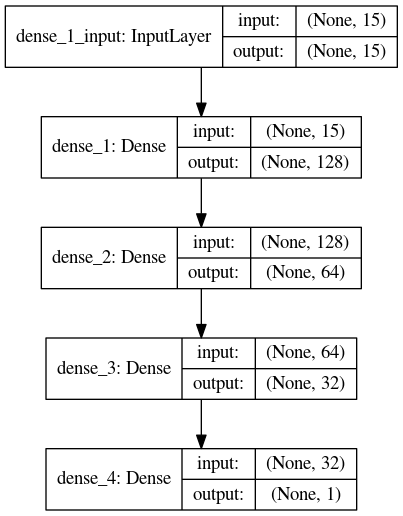

In [6]:
dense_model1 = Sequential([ Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(64,  activation='relu'),
                     Dense(32,  activation='relu'),
                     Dense(1,   activation='sigmoid')])

print(dense_model1.summary())
plot_model(dense_model1, to_file='dense1.png', show_shapes=True)
Image.open('dense1.png')

## Compiling Model
Compiling Model involves setting optimizers to use, loss and evaluation metrics.

In [7]:
dense_model1.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model
Below we are fitting model with batch size of 4 for 25 epochs. We'll use 10% of train data as validation data for evaluation of performance during training.

In [8]:
history = dense_model1.fit(X_train, Y_train, batch_size=4, epochs=25, validation_split=0.1, shuffle=False, use_multiprocessing=True);

Train on 2232 samples, validate on 248 samples
Epoch 1/25
2232/2232 [==============================] - 1s 517us/step - loss: 0.7726 - accuracy: 0.6671 - val_loss: 0.5846 - val_accuracy: 0.6250
Epoch 2/25
2232/2232 [==============================] - 1s 387us/step - loss: 0.5152 - accuracy: 0.7496 - val_loss: 0.4840 - val_accuracy: 0.7298
Epoch 3/25
2232/2232 [==============================] - 1s 378us/step - loss: 0.4921 - accuracy: 0.7675 - val_loss: 0.4762 - val_accuracy: 0.7379
Epoch 4/25
2232/2232 [==============================] - 1s 381us/step - loss: 0.4321 - accuracy: 0.7997 - val_loss: 0.4003 - val_accuracy: 0.8266
Epoch 5/25
2232/2232 [==============================] - 1s 373us/step - loss: 0.4069 - accuracy: 0.8221 - val_loss: 0.3809 - val_accuracy: 0.8427
Epoch 6/25
2232/2232 [==============================] - 1s 374us/step - loss: 0.3896 - accuracy: 0.8280 - val_loss: 0.3855 - val_accuracy: 0.8427
Epoch 7/25
2232/2232 [==============================] - 1s 374us/step - loss:

## Visualizing Training Stage Results

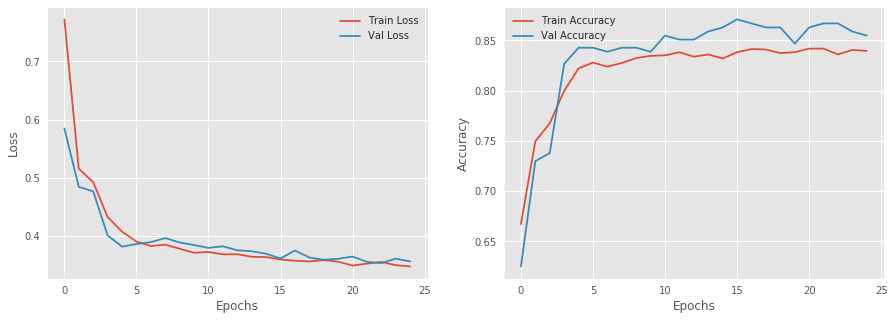

In [9]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [10]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.837


In [11]:
predictions_full = dense_model1.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))
data['Predictions_DenseNet1'] = predictions_full.flatten()

Accuracy : 0.847


## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       127
           1       0.84      0.87      0.85       149

    accuracy                           0.84       276
   macro avg       0.84      0.83      0.84       276
weighted avg       0.84      0.84      0.84       276

Confusion Matrix : 
 [[102  25]
 [ 20 129]]


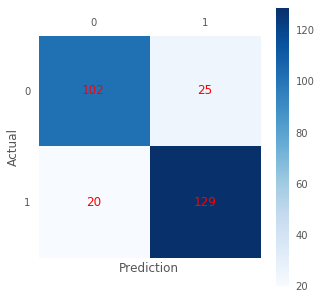

In [12]:
results = []
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    wr_mlp, vals, mdd_mlp = WR(actual_rets_test,predictions), ARR(actual_rets_test,predictions), MDD(actual_rets_test,predictions)
    arr_mlp, asr_mlp=vals[0], vals[1]
    results.append([model_name, wr_mlp, arr_mlp, asr_mlp, mdd_mlp])

    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)

print_plot_metrics('DenseNetv1', actual_rets_test, Y_test, predictions)

# DenseNet v2
Below we have deisigned another dense net model which has 6 layers of shapes 512,256,128,64,32 and 1 respectively. We have used relu as activation function for internal layers and sigmoid for last layer. We also have used Dropout of 20% this time between each layer to see whether it help improve performance.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

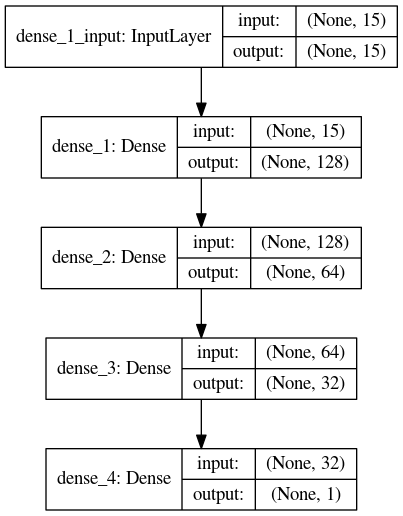

In [13]:
dense_model2 = Sequential([ 
                     Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.2),
                     Dense(256,  activation='relu'),
                     Dropout(0.2),
                     Dense(128,  activation='relu'),
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     Dropout(0.2),
                     Dense(1,   activation='sigmoid')])

print(dense_model2.summary())
plot_model(dense_model1, to_file='dense2.png', show_shapes=True)
Image.open('dense2.png')

## Compiling Model

In [14]:
dense_model2.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model

In [15]:
history = dense_model2.fit(X_train, Y_train, batch_size=4, epochs=25, validation_split=0.1, shuffle=False, use_multiprocessing=True);

Train on 2232 samples, validate on 248 samples
Epoch 1/25
2232/2232 [==============================] - 2s 1ms/step - loss: 0.7726 - accuracy: 0.6084 - val_loss: 0.5817 - val_accuracy: 0.6492
Epoch 2/25
2232/2232 [==============================] - 2s 890us/step - loss: 0.6306 - accuracy: 0.6532 - val_loss: 0.6156 - val_accuracy: 0.6855
Epoch 3/25
2232/2232 [==============================] - 2s 906us/step - loss: 0.5894 - accuracy: 0.6698 - val_loss: 0.4896 - val_accuracy: 0.7500
Epoch 4/25
2232/2232 [==============================] - 2s 926us/step - loss: 0.5364 - accuracy: 0.7478 - val_loss: 0.5116 - val_accuracy: 0.7339
Epoch 5/25
2232/2232 [==============================] - 2s 939us/step - loss: 0.4867 - accuracy: 0.7702 - val_loss: 0.4617 - val_accuracy: 0.8266
Epoch 6/25
2232/2232 [==============================] - 2s 920us/step - loss: 0.4520 - accuracy: 0.8069 - val_loss: 0.3741 - val_accuracy: 0.8427
Epoch 7/25
2232/2232 [==============================] - 2s 857us/step - loss: 0

## Visualising Training Stage Results

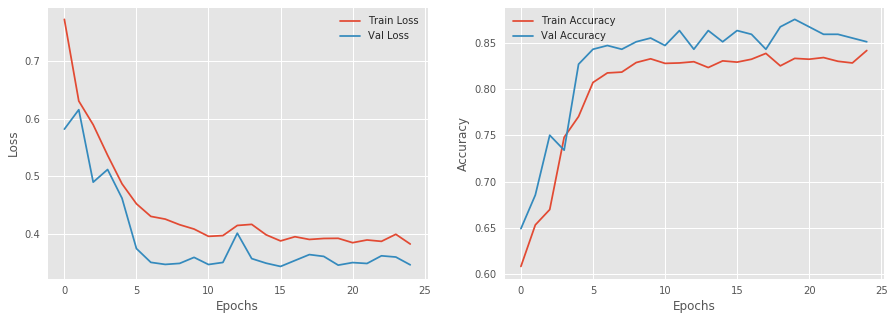

In [16]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [17]:
predictions = dense_model2.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.848


In [18]:
predictions_full = dense_model2.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))
data['Predictions_DenseNet2'] = predictions_full.flatten()

Accuracy : 0.849


## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       127
           1       0.88      0.83      0.86       149

    accuracy                           0.85       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.85      0.85      0.85       276

Confusion Matrix : 
 [[110  17]
 [ 25 124]]


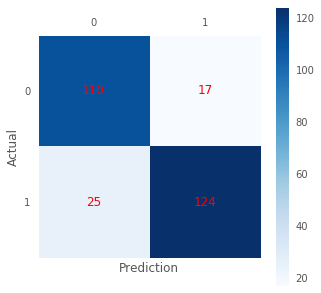

In [19]:
print_plot_metrics('DenseNetv2', actual_rets_test, Y_test, predictions)

# Time Series Approach With LSTM (Classification) v1

Below we are preparing data for LSTM. We are taking look back size of 50 so that we'll look at 50 previous sample to predict current one. We are organizing our dataset in that format so that it can be fed into LSTM.

In [20]:
def prepare_dataset(features,labels, look_back=1):
    X, Y = [], []
    for i in range(len(features)-look_back):
        a = features[i:(i+look_back), :]
        X.append(a)
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
Y = data['label'].values
ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)
actual_rets_test = ret_vals[X_train.shape[0]:]

print('Actual Data Size : ', X.shape, Y.shape)
print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

# split into input and outputs
look_back = 50
X_train, Y_train = prepare_dataset(X_train, Y_train, look_back)
X_test, Y_test = prepare_dataset(X_test, Y_test, look_back)

X_new, Y_new = prepare_dataset(X, Y, look_back)
print('Modified Data Size : ', X_new.shape, Y_new.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Actual Data Size :  (2756, 15) (2756,)
Train/Test Sizes :  (2480, 15) (276, 15) (2480,) (276,)
Actual Return Sizes :  (276,)
Modified Data Size :  (2706, 50, 15) (2706,)
Train/Test Sizes Modified (2430, 50, 15) (2430,) (226, 50, 15) (226,)


Below we have defined LSTM network of only 50 units. This parameter can be tweaked to check whether it improves performance further in future. My guess is that if we increase its value further then it'll performance. Output layer is again sigmoid.

In [21]:
lstm_classif = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.2),
                        Dense(1, activation='sigmoid')                        
                        ])

## Compiling Model

In [22]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [23]:
history = lstm_classif.fit(X_train, Y_train, epochs=30, batch_size=8, validation_data=(X_test, Y_test), verbose=1, shuffle=False)

Train on 2430 samples, validate on 226 samples
Epoch 1/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.7144 - accuracy: 0.5148 - val_loss: 0.7079 - val_accuracy: 0.4735
Epoch 2/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.6988 - accuracy: 0.5309 - val_loss: 0.7005 - val_accuracy: 0.5088
Epoch 3/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.6975 - accuracy: 0.5239 - val_loss: 0.7112 - val_accuracy: 0.4646
Epoch 4/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.6929 - accuracy: 0.5333 - val_loss: 0.7023 - val_accuracy: 0.4646
Epoch 5/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.6929 - accuracy: 0.5255 - val_loss: 0.7056 - val_accuracy: 0.4513
Epoch 6/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.6896 - accuracy: 0.5325 - val_loss: 0.7085 - val_accuracy: 0.4469
Epoch 7/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.6859 - accu

## Visualizing Training Stage Results

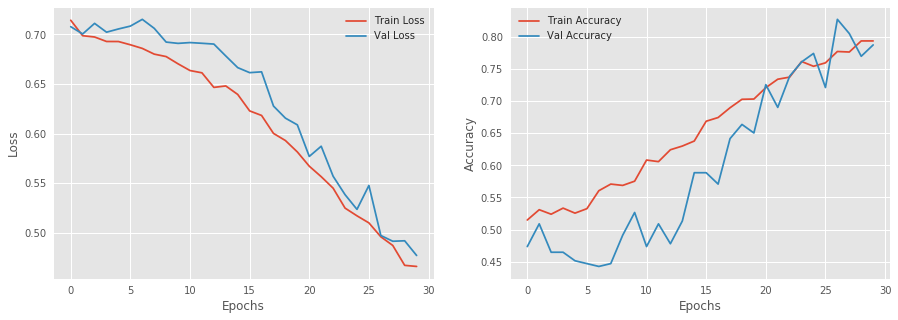

In [24]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [25]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.788


In [26]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))
data['Predictions_LSTMv1'] = np.hstack((np.zeros(look_back),predictions_full.flatten()))

Accuracy : 0.839


## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.77      0.79      0.78       107
           1       0.81      0.78      0.79       119

    accuracy                           0.79       226
   macro avg       0.79      0.79      0.79       226
weighted avg       0.79      0.79      0.79       226

Confusion Matrix : 
 [[85 22]
 [26 93]]


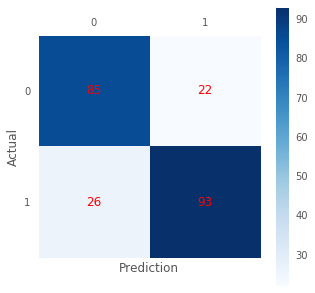

In [27]:
print_plot_metrics('LSTMv1', actual_rets_test, Y_test, predictions)

# Time Series Approach With LSTM (Classification) v2
Below we have defined another LSTM model which has 3 LSTM layers of all same unit sizes of 30. Last layer is again sigmoid layer.

In [28]:
lstm_classif = Sequential([
                LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=30, return_sequences=True),
                LSTM(units=30),
                Dense(1, activation='sigmoid')
                ])

## Compiling Model

In [29]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [30]:
history = lstm_classif.fit(X_train, Y_train, epochs=30, batch_size=8, validation_data=(X_test, Y_test), verbose=1, shuffle=False)

Train on 2430 samples, validate on 226 samples
Epoch 1/30
2430/2430 [==============================] - 20s 8ms/step - loss: 0.6963 - accuracy: 0.5033 - val_loss: 0.6930 - val_accuracy: 0.5265
Epoch 2/30
2430/2430 [==============================] - 19s 8ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6922 - val_accuracy: 0.5354
Epoch 3/30
2430/2430 [==============================] - 20s 8ms/step - loss: 0.6925 - accuracy: 0.5189 - val_loss: 0.6909 - val_accuracy: 0.5487
Epoch 4/30
2430/2430 [==============================] - 19s 8ms/step - loss: 0.6922 - accuracy: 0.5230 - val_loss: 0.6911 - val_accuracy: 0.5398
Epoch 5/30
2430/2430 [==============================] - 19s 8ms/step - loss: 0.6919 - accuracy: 0.5206 - val_loss: 0.6940 - val_accuracy: 0.5398
Epoch 6/30
2430/2430 [==============================] - 19s 8ms/step - loss: 0.6914 - accuracy: 0.5214 - val_loss: 0.6935 - val_accuracy: 0.5265
Epoch 7/30
2430/2430 [==============================] - 19s 8ms/step - loss: 0.6909

## Visualizing Training Stage Results

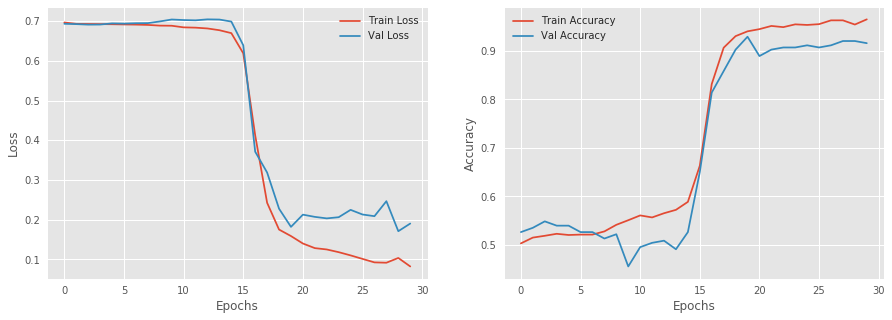

In [31]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [32]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.916


In [33]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))
data['Predictions_LSTMv2'] = np.hstack((np.zeros(look_back),predictions_full.flatten()))


Accuracy : 0.957


## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       107
           1       0.91      0.93      0.92       119

    accuracy                           0.92       226
   macro avg       0.92      0.91      0.92       226
weighted avg       0.92      0.92      0.92       226

Confusion Matrix : 
 [[ 96  11]
 [  8 111]]


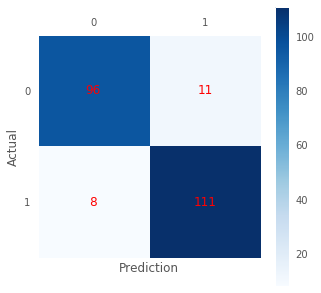

In [34]:
print_plot_metrics('LSTMv2' , actual_rets_test, Y_test, predictions)

In [35]:
result_df=pd.DataFrame(results, columns=['Model', 'WR','ARR','ASR','MDD'])
result_df

,Model,WR,ARR,ASR,MDD
0,DenseNetv1,149.0,9.915e+07,61.37,0.387
1,DenseNetv2,149.0,9.915e+07,61.37,0.387
2,LSTMv1,149.0,9.915e+07,61.37,0.387
3,LSTMv2,149.0,9.915e+07,61.37,0.387


# Time Series with LSTM (Regression - Returns Prediction)

Below we are preparing data for regression problem where we are using returns as prediction. Process is totally same as above only differnece is that we are using returns as prediction column now.

In [36]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
Y = data['label'].values
ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)
actual_rets_test = ret_vals[X_train.shape[0]:]

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

# split into input and outputs
look_back = 50
X_train, Y_train = prepare_dataset(X_train, ret_vals[:int(len(X)*0.9)], look_back)
X_test, Y_test = prepare_dataset(X_test, ret_vals[int(len(X)*0.9):], look_back)
X_new, ret_vals_new = prepare_dataset(X, ret_vals, look_back)

print('Modified Data Size : ', X_new.shape, ret_vals_new.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Train/Test Sizes :  (2480, 15) (276, 15) (2480,) (276,)
Actual Return Sizes :  (276,)
Modified Data Size :  (2706, 50, 15) (2706,)
Train/Test Sizes Modified (2430, 50, 15) (2430,) (226, 50, 15) (226,)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                20480     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 20,545
Trainable params: 20,545
Non-trainable params: 0
_________________________________________________________________
None


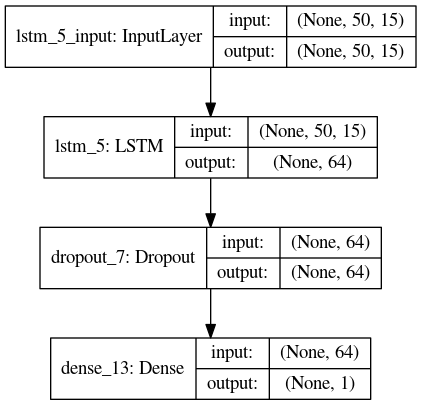

In [37]:
# design network
lstm_regression = Sequential([
                    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
                    Dropout(0.2),
                    Dense(1)
                ])
print(lstm_regression.summary())
plot_model(lstm_regression, 'lstm_regression.png', show_shapes=True)
Image.open('lstm_regression.png')

## Compiling Model

In [38]:
lstm_regression.compile(loss='mse', optimizer='adam', metrics=['mse'])

## Fitting Model

In [39]:
history = lstm_regression.fit(X_train, Y_train, epochs=25, batch_size=8, validation_data=(X_test, Y_test), verbose=1, shuffle=False)

Train on 2430 samples, validate on 226 samples
Epoch 1/25
2430/2430 [==============================] - 8s 3ms/step - loss: 0.1288 - mse: 0.1288 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 2/25
2430/2430 [==============================] - 7s 3ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 3/25
2430/2430 [==============================] - 7s 3ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/25
2430/2430 [==============================] - 7s 3ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/25
2430/2430 [==============================] - 7s 3ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 7.4657e-04 - val_mse: 7.4657e-04
Epoch 6/25
2430/2430 [==============================] - 7s 3ms/step - loss: 6.8950e-04 - mse: 6.8950e-04 - val_loss: 6.0176e-04 - val_mse: 6.0176e-04
Epoch 7/25
2430/2430 [==============================] - 7s 3ms/step - loss: 4.8119e-04 - mse: 4.8119e-04 - val_loss: 5.1905e-

## Visualizing Training Stage Results

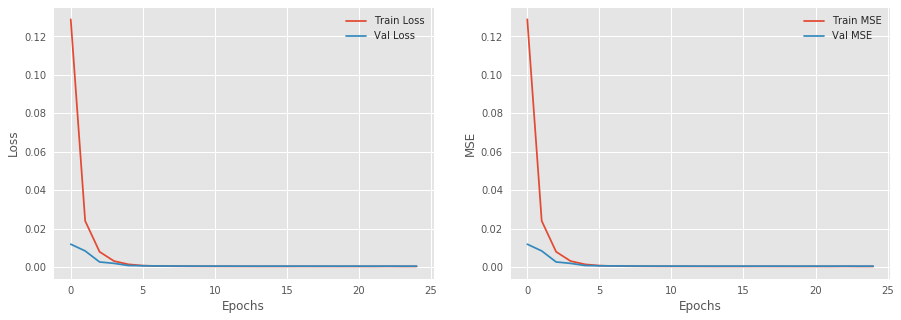

In [40]:
plot_loss_and_accuracy(history, 'regression')

## Performance Evaluation on Test Data

In [41]:
predictions = lstm_regression.predict(X_test)
print('MSE       : %.3f'%mean_squared_error(Y_test, predictions))
print('R^2 Score : %.3f'%r2_score(Y_test, predictions))

MSE       : 0.000
R^2 Score : -0.016


In [42]:
predictions_full = lstm_regression.predict(X_new)
print('MSE       : %.3f'%mean_squared_error(ret_vals_new, predictions_full))
print('R^2 Score : %.3f'%r2_score(ret_vals_new, predictions_full))
data['Ret_Vals_Predictions_LSTM'] = np.hstack((np.zeros(look_back),predictions_full.flatten()))


MSE       : 0.000
R^2 Score : 0.099


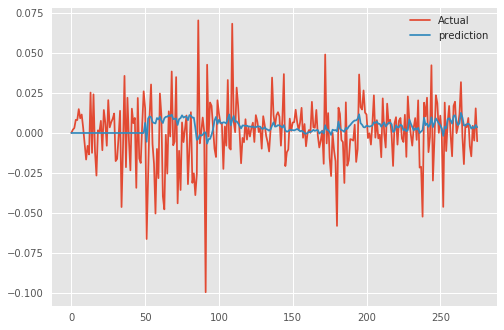

In [43]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.plot(actual_rets_test, label='Actual')
    plt.plot(np.hstack((np.zeros(look_back), predictions.flatten())), label='prediction')
    plt.legend(loc='best')

In [44]:
data.to_csv('Final_Output.csv')